# 💵 Détection des faux Billets

Ce projet a pour but de créer un algorithme de détection de faux billets et revoir des notions vues aux épisodes précédents.

Le [jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/notes.csv)  contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons :

 - la longueur du billet (en mm) ;  
 - la hauteur du billet (mesurée sur le côté gauche, en mm) ;  
 - La hauteur du billet (mesurée sur le côté droit, en mm) ;  
 - la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  
 - la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  
 - la diagonale du billet (en mm).

L'étude va consister en 3 parties : 

Partie 1 : analyse exploratoire univariée et bivariée de votre jeu de données  

Partie 2 : ACP 
    Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :  
        - choix du nombre des composantes
        - représentation des variables par le cercle des corrélations 
        - représentation des individus par les plans factoriels 
        - analyser de la qualité de représentation et la contribution des individus.
Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

Partie 3 : Réaliser une classification des billets (révisions de kmeans ou régression logique, et aller creuser côté CAH)

# 📜 SUMMARY

* [Exploratory Data Analysis (EDA)](#📊-Partie-1-:-Exploratory-Data-Analysis-(EDA))
    * [Visualisation](#👀-Visualisation)
* [PAC](#📈-Partie-2-:-ANALYSE-EN-COMPOSANTES-PRINCIPALES)
* [Prediction](#🔮-Partie-3-:-PREDICTION)
    * [Logistic regression](#Logistic-regression-(after-PCA)
    * [K-Means](#K-MEANS-(after-PCA)
    * [Decision Tree](#Decision-Tree)
* [CAH](#Classification-ascendante-hiérarchique-(CAH)

In [343]:
# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
#classe pour l'ACP
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt

#RegLog Kmeans
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#CAH
from scipy.cluster.hierarchy import dendrogram, linkage

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.api import Logit

from mlxtend.plotting import plot_pca_correlation_graph

import warnings
warnings.filterwarnings('ignore')

## 📊 Partie 1 : Exploratory Data Analysis (EDA)

Dans cette partie, vous allez explorer vos données via des visualisations, par exemple :   
    
    - le nombre de billets vrai/faux  
    - les distributions de longueurs, largeurs and co des billets de votre dataset
    - longueur/largeur and co des billets vrais vs. faux : est-ce que visuellement on peut déterminer des caractéristiques des vrais ou des faux billets ?
    - etc -> be creative :)

In [344]:
# load dataset
df = pd.read_csv('notes.csv')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [345]:
# basic informations about dataset (numbers of rows, columns)
df.shape

(170, 7)

In [346]:
# count of missing values in dataset and where are they
df.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [347]:
# basics informations about dataset (mean, min, ect...)
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [348]:
# number of true and false bills
# 100 bills are true
# 70 bills are false
df.is_genuine.value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

# 👀 Visualisation

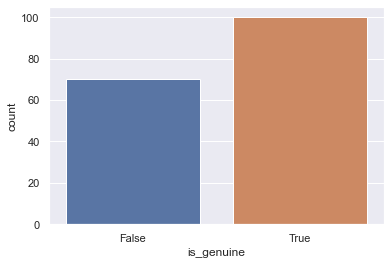

In [349]:
# countplot / The bills are genuine ?
sns.set()
ax = sns.countplot(x="is_genuine", data=df)

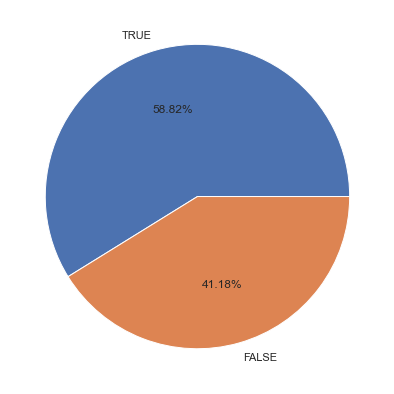

In [350]:
# pie chart / The bills are genuine ?
plt.figure(figsize=(10,7))
labels= 'TRUE','FALSE'
plt.pie(df['is_genuine'].value_counts(),labels=labels,autopct='%0.02f%%')
plt.show()

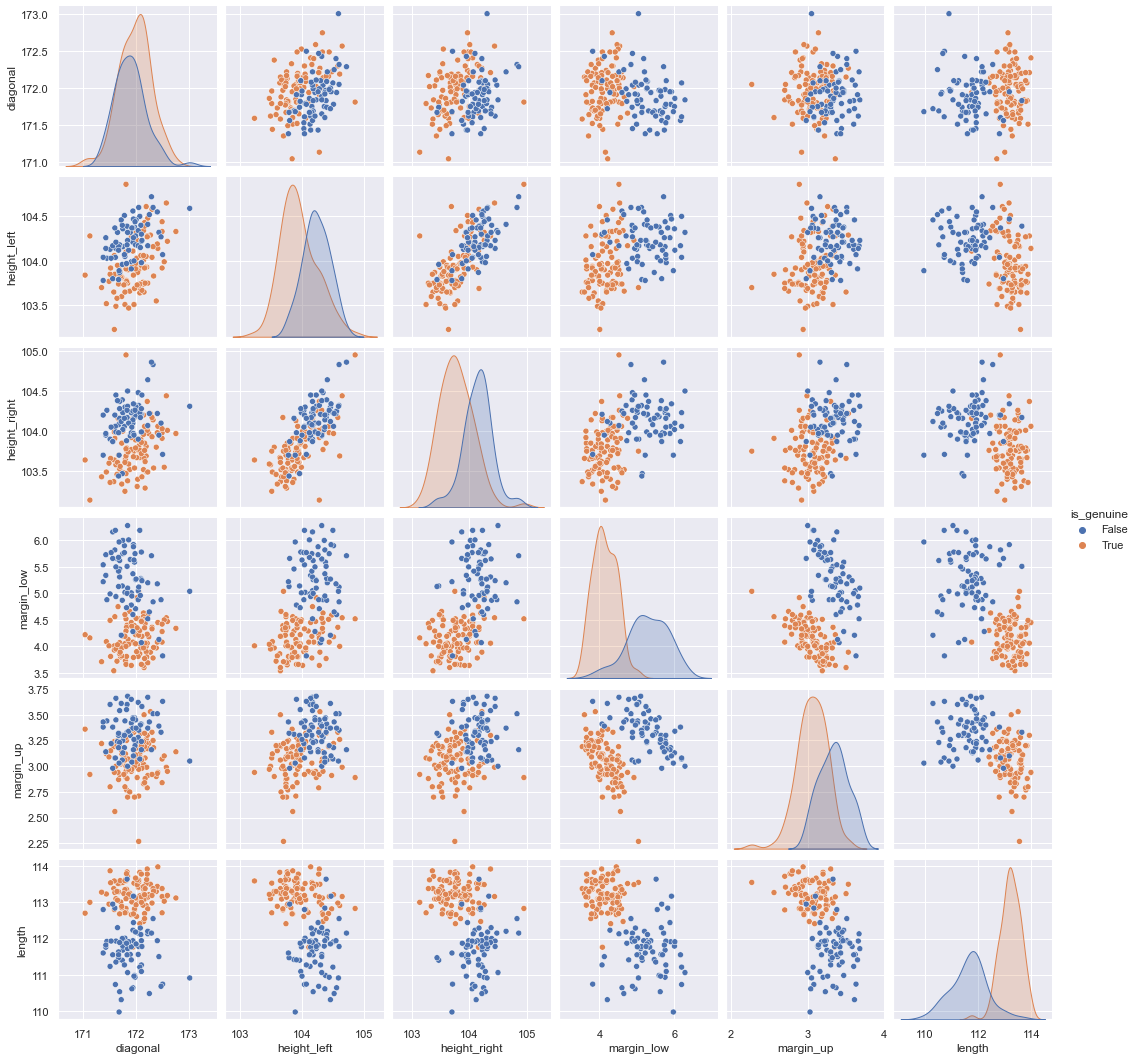

In [351]:
# pairplot / True bills in orange, False bills in blue / I see the difference between
sns.pairplot(df, hue="is_genuine")
plt.show()

<AxesSubplot:>

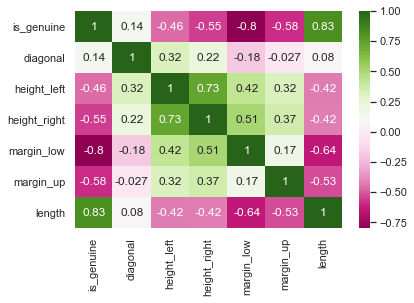

In [352]:
# correlation matrix
sns.heatmap(df.corr(), annot=True, cmap="PiYG")

## 📈 Partie 2 : ANALYSE EN COMPOSANTES PRINCIPALES

Repartez de l'exploration via l'étude VISA pour cette partie + le cours sur OC
Dans tous les cas, je veux voir ce que j'ai cité plus haut.

In [354]:
# define features (variable name), X & y (target)
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
X = df.drop(['is_genuine'], axis = 1)
y = df['is_genuine']

In [355]:
# standardizing the features (scaling)
X_std = StandardScaler().fit_transform(X)

In [356]:
# PCA without number of components for see all the explained variance ratio
pca = PCA()
pca_without = pca.fit(X_std).transform(X_std)
pca.explained_variance_ratio_

array([0.47447921, 0.21957106, 0.14234524, 0.08526295, 0.04612822,
       0.03221331])

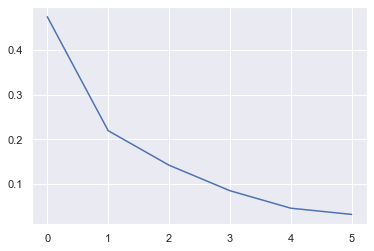

In [357]:
# plot explained variance
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [358]:
# PCA with 2 principal components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X_std)
pca_df = pd.DataFrame(data = principalComponents, 
                             columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [359]:
# PCA with 3 principal components in dataframe
pca_df

,principal component 1,principal component 2,principal component 3
0,2.153639,1.599709,1.787451
1,-2.110416,-0.526039,0.542563
2,-1.973152,-0.048102,0.858716
3,-2.059795,-0.089105,-0.531529
4,-2.403180,0.412170,3.319507
...,...,...,...
165,2.478626,0.189974,-0.814598
166,2.585331,2.914472,0.586789
167,2.067245,0.845602,-0.610282
168,0.739257,-0.972965,-1.359772


In [360]:
# in Principal component 1, I have 47% of data
# in Principal component 2, I have 22% of data
# in Principal component 3, I have 14% of data
# so I have 83,6% of data in total
# pca.explained_variance_ratio_.cumsum()
pca.explained_variance_ratio_

array([0.47447921, 0.21957106, 0.14234524])

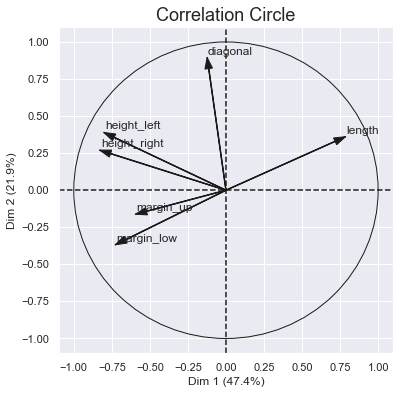

In [361]:
# correlation circle
figure, correlation_matrix = plot_pca_correlation_graph(X_std,
                                                        features,
                                                        dimensions=(1,2),
                                                        figure_axis_size=6)

## 🔮 Partie 3 : PREDICTION

Effectuer la prédiction de nouveaux billets via un algorithme que vous allez mettre en place (kmeans? regression logistique? A vous de voir).  

# Logistic regression (after PCA)

In [362]:
# define X & y
X = pca_df
y = df['is_genuine']

In [363]:
# logistic regression
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.2)

model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression()

In [364]:
# prediction
y_pred = model.predict(X_test)

In [365]:
# score (precision, accuracy, recall, F1)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)

print("Classification report:\n\n", class_report)
print("Confusion Matrix\n",conf_matrix)
print("\nAccuracy\n",acc)

Classification report:

               precision    recall  f1-score   support

       False       0.94      0.98      0.96        59
        True       0.99      0.95      0.97        77

    accuracy                           0.96       136
   macro avg       0.96      0.97      0.96       136
weighted avg       0.96      0.96      0.96       136

Confusion Matrix
 [[58  1]
 [ 4 73]]

Accuracy
 0.9632352941176471


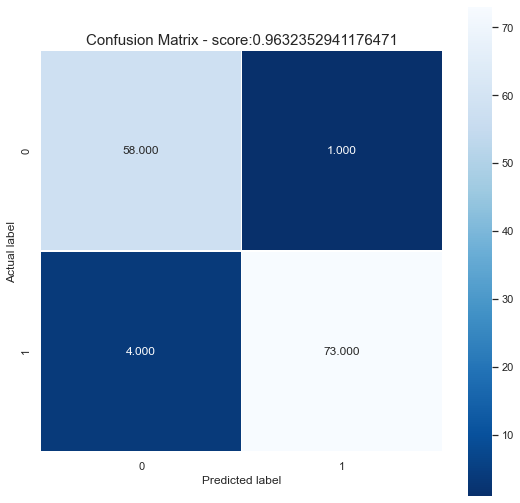

In [366]:
# confusion matrix
plt.figure(figsize=(9,9))
sns.heatmap(conf_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_test,y_pred))
plt.title(all_sample_title, size = 15)
plt.show()

In [267]:
# 2 false negative / 2 false positive / 55 true positive / 78 true negative

# K-MEANS (after PCA)

In [367]:
# define X & y
X = pca_df
y = df['is_genuine']

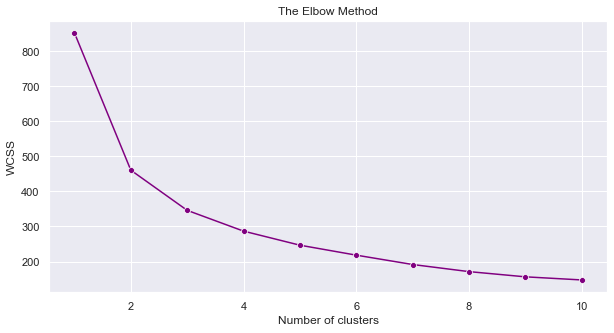

In [368]:
# use Elbow Method to choose the number of clusters (even if in this dataset, we already know it (true / false so 2) )
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 3)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='purple')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [369]:
# fitting K-Means to the dataset(2 clusters)
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 5)
y_kmeans = kmeans.fit_predict(X)

Text(0, 0.5, 'principal component 1')

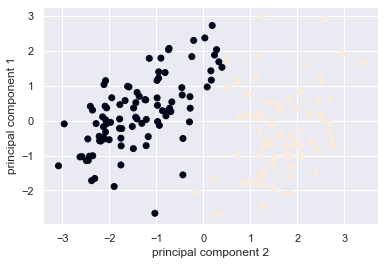

In [370]:
# visualisation K-Means
plt.scatter(pca_df['principal component 1'],pca_df['principal component 2'], c=y_kmeans)
plt.xlabel('principal component 2')
plt.ylabel('principal component 1')

# Decision Tree

In [373]:
# import library
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import plot_confusion_matrix

In [374]:
# accuracy with decision tree : 92.64%
tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

precision = metrics.accuracy_score(y_pred, y_test) * 100
precision

92.64705882352942

# Classification ascendante hiérarchique (CAH)

In [375]:
Z = linkage(pca_df,method='ward',metric='euclidean')

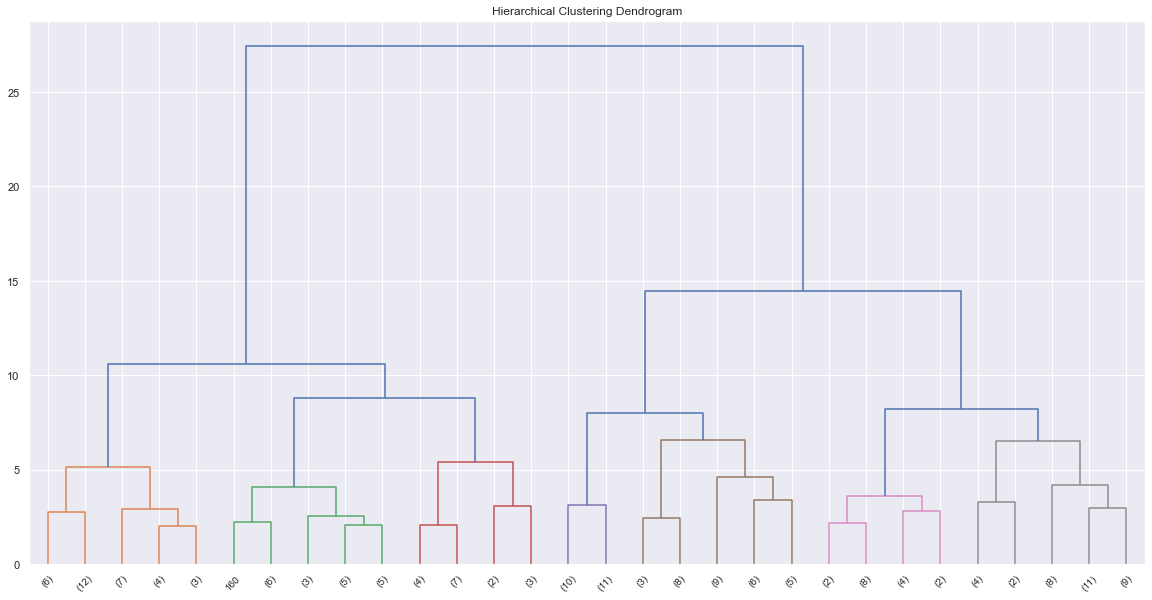

In [376]:
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z,color_threshold=7, truncate_mode='lastp')
plt.show()